In [ ]:
from __future__ import absolute_import, division, print_function

import pprint
import argparse
import logging
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # Set GPU Index to use
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import sys
import pickle
import copy
import collections
import math

import numpy as np
import numpy
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler,TensorDataset
# from torch.utils.tensorboard import SummaryWriter

from torch.nn import CrossEntropyLoss, MSELoss
from tqdm import tqdm
from transformer import BertForSequenceClassification,WEIGHTS_NAME, CONFIG_NAME
from transformer.modeling_quant import BertForSequenceClassification as QuantBertForSequenceClassification
from transformer import BertTokenizer
from transformer import BertAdam
from transformer import BertConfig
from transformer import QuantizeLinear, QuantizeAct, BertSelfAttention, FP_BertSelfAttention, ClipLinear
from utils_glue import *
from bertviz import model_view

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
        
def get_tensor_data(output_mode, features):
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)


    all_seq_lengths = torch.tensor([f.seq_length for f in features], dtype=torch.long)
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    tensor_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,all_label_ids, all_seq_lengths)
    return tensor_data, all_label_ids

def do_eval(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels, teacher_model=None):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    for batch_ in tqdm(eval_dataloader, desc="Inference"):
        batch_ = tuple(t.to(device) for t in batch_)
        
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # teacher attnmap test
            if teacher_model is not None: 
                teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_values = teacher_model(input_ids, segment_ids, input_mask)
                logits, loss, cls_loss, rep_loss, output_loss, attmap_loss, attscore_loss, coeff_list, _  = model(input_ids, segment_ids, input_mask, teacher_outputs=(teacher_probs, teacher_values, teacher_reps, teacher_logits, teacher_atts), output_mode=output_mode, seq_lengths=seq_lengths)
            else:
                outputs = model(input_ids, segment_ids, input_mask)
                logits = outputs[0]
                
        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss
    return result

def soft_cross_entropy(predicts, targets):
    student_likelihood = torch.nn.functional.log_softmax(predicts, dim=-1)
    targets_prob = torch.nn.functional.softmax(targets, dim=-1)
    return torch.sum((- targets_prob * student_likelihood), dim=-1).mean()

processors = {
    "cola": ColaProcessor,
    "mnli": MnliProcessor,
    "mnli-mm": MnliMismatchedProcessor,
    "mrpc": MrpcProcessor,
    "sst-2": Sst2Processor,
    "sts-b": StsbProcessor,
    "qqp": QqpProcessor,
    "qnli": QnliProcessor,
    "rte": RteProcessor   
}

output_modes = {
        "cola": "classification",
        "mnli": "classification",
        "mrpc": "classification",
        "sst-2": "classification",
        "sts-b": "regression",
        "qqp": "classification",
        "qnli": "classification",
        "rte": "classification"
}

default_params = {
        "cola": {"max_seq_length": 64,"batch_size":1,"eval_step": 50}, # No Aug : 50 Aug : 400
        "mnli": {"max_seq_length": 128,"batch_size":1,"eval_step":8000},
        "mrpc": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "sst-2": {"max_seq_length": 64,"batch_size":1,"eval_step":100},
        "sts-b": {"max_seq_length": 128,"batch_size":1,"eval_step":100},
        "qqp": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "qnli": {"max_seq_length": 128,"batch_size":1,"eval_step":1000},
        "rte": {"max_seq_length": 128,"batch_size":1,"eval_step": 20}
    }

## Task

In [ ]:
task_name = "cola"
bert_size = "base"

if bert_size == "large":
    layer_num = 24
    head_num = 16
else: 
    layer_num = 12
    head_num = 12

## Dataset Input Setting

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

teacher_model_dir = os.path.join(model_dir,task_name)

# Processor & Task Info
processor = processors[task_name]()
output_mode = output_modes[task_name]
label_list = processor.get_labels()
num_labels = len(label_list)

if task_name in default_params:
    batch_size = default_params[task_name]["batch_size"]
    max_seq_length = default_params[task_name]["max_seq_length"]
    eval_step = default_params[task_name]["eval_step"]
    
# Tokenizer
tokenizer = BertTokenizer.from_pretrained(teacher_model_dir, do_lower_case=True)


# Load Dataset
data_dir = os.path.join("data",task_name)
processed_data_dir = os.path.join(data_dir,'preprocessed')

eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
# dev_file = train_file = os.path.join(processed_data_dir,'dev.pkl') 
# eval_features = pickle.load(open(dev_file,'rb'))

eval_data, eval_labels = get_tensor_data("classification", eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=1)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)

eval_examples = processor.get_dev_examples(data_dir)

# Sampling Sentence 
i = 0 
# num = 3
num = 43

for step, batch in enumerate(eval_dataloader):
    # model.train()
            
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch
    i = i + 1
    if i == num:
        break

seq_length = seq_lengths.item()

input_ids_sliced = input_ids[:,:seq_length]
input_id = []
for i in input_ids_sliced[0]:
    input_id.append(i.item())
tokens = tokenizer.convert_ids_to_tokens(input_id)



sample_sentence_a = str()
sample_sentence_b = str()
index = 0

for i, word in enumerate(tokens[1:-1]):
    if word == "[SEP]":
        break
    sample_sentence_a += word
    sample_sentence_a += " "
index = i

for i, word in enumerate(tokens[index+2:-1]):
    if word == "[SEP]":
        break
    sample_sentence_b += word
    sample_sentence_b += " "

sep_index = torch.where(input_ids[0] == 102)[0]

if len(sample_sentence_b) > 1:
    sample_sentence_b_start = segment_ids[0].tolist().index(1)
else:
    sample_sentence_b_start = None

print(f"input_ids : {input_ids_sliced}")
print(f"tokens : {tokens}")
print(f"A : {sample_sentence_a}")
print(f"B : {sample_sentence_b}")
print(sep_index)

for i, token in enumerate(tokens):
    tokens[i] = token


## Model Load

In [31]:
st_model = "Q" # QAT, Q

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_dir = "models"
output_dir = "output"

if bert_size == "large":
    model_dir = os.path.join(model_dir, "BERT_large")
    output_dir = os.path.join(output_dir, "BERT_large")

# Teacher Model Load
student_model_dir = os.path.join(model_dir,task_name)
teacher_model_dir = os.path.join(model_dir,task_name)

teacher_model = BertForSequenceClassification.from_pretrained(teacher_model_dir, num_labels=num_labels)
teacher_model.to(device)
teacher_model.eval()
# Inference
teacher_logits, teacher_atts, teacher_reps, teacher_probs, teacher_zip = teacher_model(input_ids_sliced.to(device)) #input_mask, segment_ids

# QAT Result Model
if st_model == "qat":
    sarq_model_name = "1SB_S"
    sarq_model_dir = os.path.join(output_dir, task_name, "exploration", sarq_model_name)  
    quant_config = BertConfig.from_pretrained(sarq_model_dir)             
    sarq_model = QuantBertForSequenceClassification.from_pretrained(sarq_model_dir, config = quant_config, num_labels=num_labels)
    # Inference
    logits, loss, cls_loss, rep_loss, output_loss, attmap_loss, attscore_loss, coeff_list, student_zip  = sarq_model(input_ids_sliced.to(device), teacher_outputs=None, output_mode=output_mode, seq_lengths=seq_lengths)


# Direct Quantization Model (Q)
if st_model == "q":
    sarq_model_name = "1SB_S"
    sarq_model_dir = os.path.join(output_dir, task_name, "exploration", sarq_model_name)  
    quant_config = BertConfig.from_pretrained(sarq_model_dir)             
    sarqr_model = QuantBertForSequenceClassification.from_pretrained(teacher_model_dir, config = quant_config, num_labels=num_labels)
    # Inference
    logits, loss, cls_loss, rep_loss, output_loss, attmap_loss, attscore_loss, coeff_list, q_zip  = sarq_model(input_ids_sliced.to(device), teacher_outputs=None, output_mode=output_mode, seq_lengths=seq_lengths)


sarq_model.to(device)
teacher_model.to(device)
sarq_model.eval()
teacher_model.eval()

print()
print("==> Load Model DONE")
print("==> Test Inference")


05/21 04:45:56 PM Loading model models/cola/pytorch_model.bin
05/21 04:45:56 PM loading model...
05/21 04:45:56 PM done!
05/21 04:45:56 PM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']
05/21 04:45:56 PM loading configuration file output/cola/exploration/1SB_S/config.json
05/21 04:45:58 PM Loading model models/cola/pytorch_model.bin
05/21 04:45:59 PM loading model...
05/21 04:45:59 PM done!
05/21 04:45:59 PM Weights from pretrained model not used in BertForSequenceClassification: ['bert.embeddings.position_ids']

==> Load Model DONE
==> Test Inference


## Attention Prob AVG

In [33]:
q_avg_attention = []
qat_avg_attention = []
tc_avg_attention = []

for l in range(12):
    tc_avg_attention.append(teacher_probs[l][0,:,:,sep_index[0]].mean().item())
    # print(teacher_probs[l][0,:,:,sep_index[0]].mean())
print()
for l in range(12):
    qat_avg_attention.append(student_zip[1][l][0,:,:,sep_index[0]].mean().item())
    # print(student_zip[1][l][0,:,:,sep_index[0]].mean())
print()
for l in range(12):
    q_avg_attention.append(q_zip[1][l][0,:,:,sep_index[0]].mean().item())
    # print(q_zip[1][l][0,:,:,sep_index[0]].mean())


## Attention Output MSE Loss

In [34]:
mse_func = MSELoss()


q_attn_output_list = []
qat_attn_output_list = []
tc_attn_output = []

for l in range(12):
    tc_attn_context, tc_attn_output, tc_value_vector, tc_sa_output = teacher_zip[l]
    st_attn_context, st_attn_output, st_value_vector, st_sa_output = student_zip[0][l]    
    q_attn_context, q_attn_output, q_value_vector, q_sa_output = q_zip[0][l]        
    
    # # print(mse_func(tc_attn_context,st_attn_context).item())
    qat_attn_output_list.append(mse_func(tc_attn_context,st_attn_context).item())
    q_attn_output_list.append(mse_func(tc_attn_context,q_attn_context).item())
    
    # print(mse_func(tc_attn_context,st_attn_context))
    # print(mse_func(tc_attn_context,q_attn_context))
    


## Save Torch File

In [1]:

torch.save(tc_avg_attention, "tc_sep_prob_avg.pt")
torch.save(q_avg_attention, "q_sep_prob_avg.pt")
torch.save(qat_avg_attention, "qat_sep_prob_avg.pt")

torch.save(q_attn_output_list, "q_attn_output_mse.pt")
torch.save(qat_attn_output_list, "qat_attn_output_mse.pt")

NameError: name 'torch' is not defined

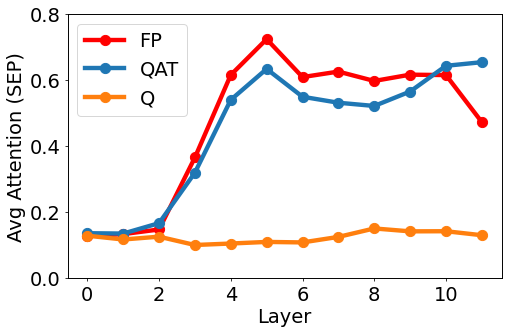

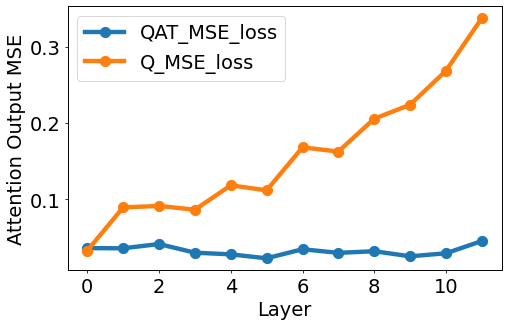

In [15]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tc_avg_attention = torch.load("tc_sep_prob_avg.pt")
q_avg_attention = torch.load("q_sep_prob_avg.pt")
qat_avg_attention = torch.load("qat_sep_prob_avg.pt")

q_attn_output_list = torch.load("q_attn_output_mse.pt")
qat_attn_output_list = torch.load("qat_attn_output_mse.pt")


plt.rcParams['axes.linewidth'] = 1
plt.rcParams['patch.linewidth'] = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=70)
lw = 4.5
fs = 20
tc_name = "FP"
qat_name = "QAT"
q_name = "Q"

tc_c = "r"
qat_c = "tab:blue"
q_c = "tab:orange"
al=1
plt.xlabel("Layer", fontsize=fs)
ax.plot(range(12), tc_avg_attention, linewidth=lw, color=tc_c, label=tc_name, alpha=al, marker="o", ms=lw+6)
ax.plot(range(12), qat_avg_attention, linewidth=lw, color=qat_c, label=qat_name, alpha=al, marker="o", ms=lw+6)
ax.plot(range(12), q_avg_attention, linewidth=lw, color=q_c, label=q_name, alpha=al, marker="o", ms=lw+6)
ax.tick_params(axis="x", labelsize=fs)
ax.tick_params(axis="y", labelsize=fs)
ax.set_ylabel("Avg Attention (SEP)", fontsize=fs)
ax.set_ylim(0, 0.8)
ax.legend(loc=2, ncol=1, fontsize=fs)
# ax2.plot(range(12), tc_attn_output, linewidth=lw, color=tc_c, label=tc_name, alpha=0.4)

fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=70)
plt.xlabel("Layer", fontsize=fs)
ax.plot(range(12), qat_attn_output_list, linewidth=lw, color=qat_c, label="QAT_MSE_loss", alpha=al, marker="o", ms=lw+6)
ax.plot(range(12), q_attn_output_list, linewidth=lw, color=q_c, label="Q_MSE_loss", alpha=al, marker="o", ms=lw+6)
ax.set_ylabel("Attention Output MSE", fontsize=fs)
ax.legend(loc=2, ncol=1, fontsize=fs)
ax.tick_params(axis="x", labelsize=fs)
ax.tick_params(axis="y", labelsize=fs)

